# Results Figure --- spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

%matplotlib inline

#### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

# Boundary coordinates:
xmin=imin+1; ymin=jmin+1;
r1i = 1520-xmin;                      r1j = np.arange(505-ymin,673-ymin)
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin #Nares
P1i = 1585-xmin;                      P1j = np.arange(485-ymin,538-ymin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]
P2i = 1664-xmin;                      P2j = np.arange(465-ymin,490-ymin);

land_color = '#a9a7a2'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

#### Load files:

In [3]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [4]:
ref     = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub = np.array(ref.variables['nav_lon'])
lat_sub = np.array(ref.variables['nav_lat'])
depth   = np.array(ref.variables['deptht'])

#### Functions:

In [5]:
def load_Mn_prop_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
    
    glacier_prop     = calculate_prop(dmn_ref, dmn_glac)
    continental_prop = calculate_prop(dmn_ref, dmn_cont)
    
    return glacier_prop, continental_prop

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [6]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off)*100*2 # times two so that 100% 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

#### Calculations:

In [7]:
glacier_prop, continental_prop = load_Mn_prop_results()

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [8]:
depths_for_prop = np.tile(e3t, (12,1,1,1))

# Depth-weighted proportion:
index_bottom = 17
depth_bottom = np.copy(hdept) # sum from surface to sea floor
depth_bottom[depth_bottom > depth[index_bottom]] = depth[index_bottom] # sum over depth from surface to index bottom
depth_bottom[depth_bottom == 0] = np.nan # where ocean depth is zero, replace depth with NaN

depth_sum_glac = np.nansum(glacier_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_sum_cont = np.nansum(continental_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_weighted_glac = depth_sum_glac/depth_bottom
depth_weighted_cont = depth_sum_cont/depth_bottom

# Mask small values:
ma_glac = np.ma.masked_where((depth_weighted_glac < 0.05), depth_weighted_glac)
ma_cont = np.ma.masked_where((depth_weighted_cont < 0.05), depth_weighted_cont)
ma_both = ma_cont + ma_glac

#### Figures

In [9]:
month = 8

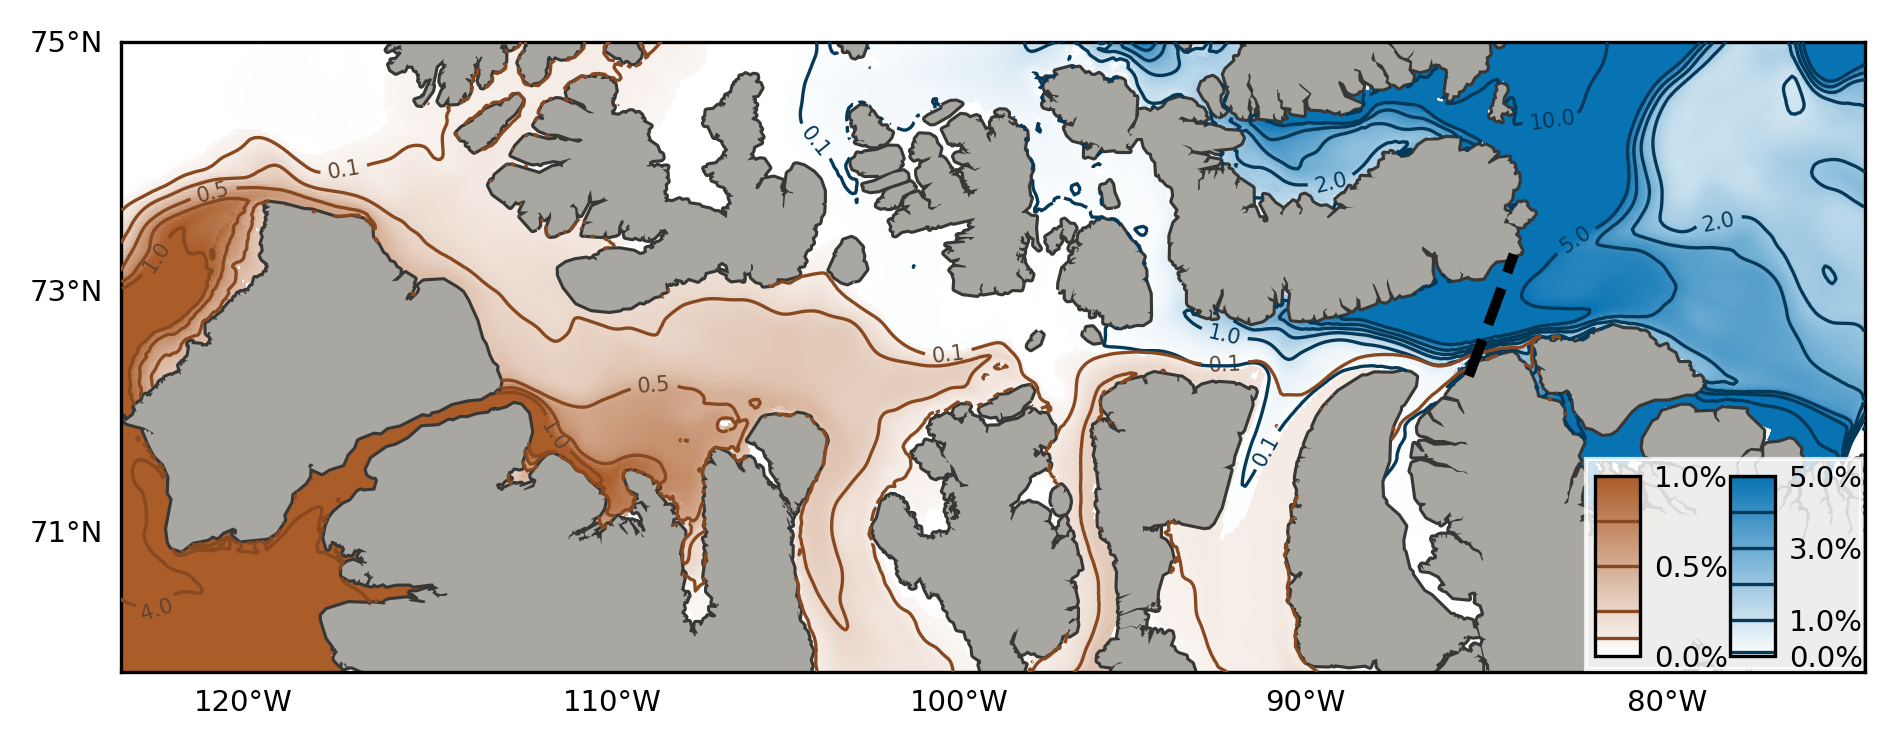

In [10]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/parry-channel.pickle','rb'))

#---------------------
x_model, y_model = proj1(lon_sub, lat_sub)

vmin_cont = 0; vmax_cont = 1;
vmin_glac = 0; vmax_glac = 5; 

# Coloured contour mesh:
CS2 = proj1.pcolormesh(x_model, y_model, ma_cont[month,:,:], vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap)
CS1 = proj1.pcolormesh(x_model, y_model, ma_glac[month,:,:], vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

# Contour lines:
glac_levels = [0.1, 1, 2, 3, 4, 5, 10]
cont_levels = [0.1, 0.25, 0.5, 0.75, 1, 4]
glac = proj1.contour(x_model, y_model, ma_glac[month,:,:], levels=glac_levels, colors='#04395a', linewidths=0.8, zorder=4)
cont = proj1.contour(x_model, y_model, ma_cont[month,:,:], levels=cont_levels, colors='#894920', linewidths=0.8, zorder=4)

# Contour line labels:
manual_locations_cont = [(4e4, 6e4), (5e4, 4.2e5), (1e5, 4.8e5), (2.3e5, 5.2e5), (5.5e5, 3e5), (8.5e5, 3.5e5), (1.14e6, 3.5e5), \
                         (4.4e5, 2.4e5)]
manual_locations_glac = [(7.2e5, 5.5e5), (1.52e6, 4.2e5), (1.65e6, 4.2e5), (1.475e6, 6e5), (1.24e6, 5.3e5), (1.2e6, 2.2e5), \
                         (1.14e6, 3.5e5)]
ax1.clabel(glac, [0.1, 1, 2, 5, 10], inline=1, fontsize=5, manual=manual_locations_glac, fmt='%.1f')
ax1.clabel(cont, [0.1, 0.5, 1, 4]  , inline=1, fontsize=5, manual=manual_locations_cont, colors='#624532', fmt='%.1f')

# Draw flux boundary:
proj1.plot(x_model[P1i, P1j], y_model[P1i, P1j], '--k', linewidth=2.5, zorder=5)
# proj1.plot(x_model[P2i, P2j], y_model[P2i, P2j], '--k', linewidth=2.5, zorder=5)

# Colorbars:
fig.patches.extend([Rectangle((1586, 85), 275, 210, color='w', alpha=0.8, zorder=6)])
cbaxes1 = fig.add_axes([0.84, 0.17, 0.02, 0.2])  
cbaxes2 = fig.add_axes([0.78, 0.17, 0.02, 0.2]) 
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=[0,1,3,5]) 
CBar2   = plt.colorbar(CS2, ax=ax1, cax=cbaxes2, ticks=[0,0.5,1])
CBar1.add_lines(glac)
CBar2.add_lines(cont)

for CBar in [CBar1, CBar2]:
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    CBar.ax.zorder = 7
    CBar.ax.set_yticklabels([f'{i:.1f}%' for i in CBar.get_ticks()])

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/R2-Parry.jpg', bbox_inches='tight', dpi=300)

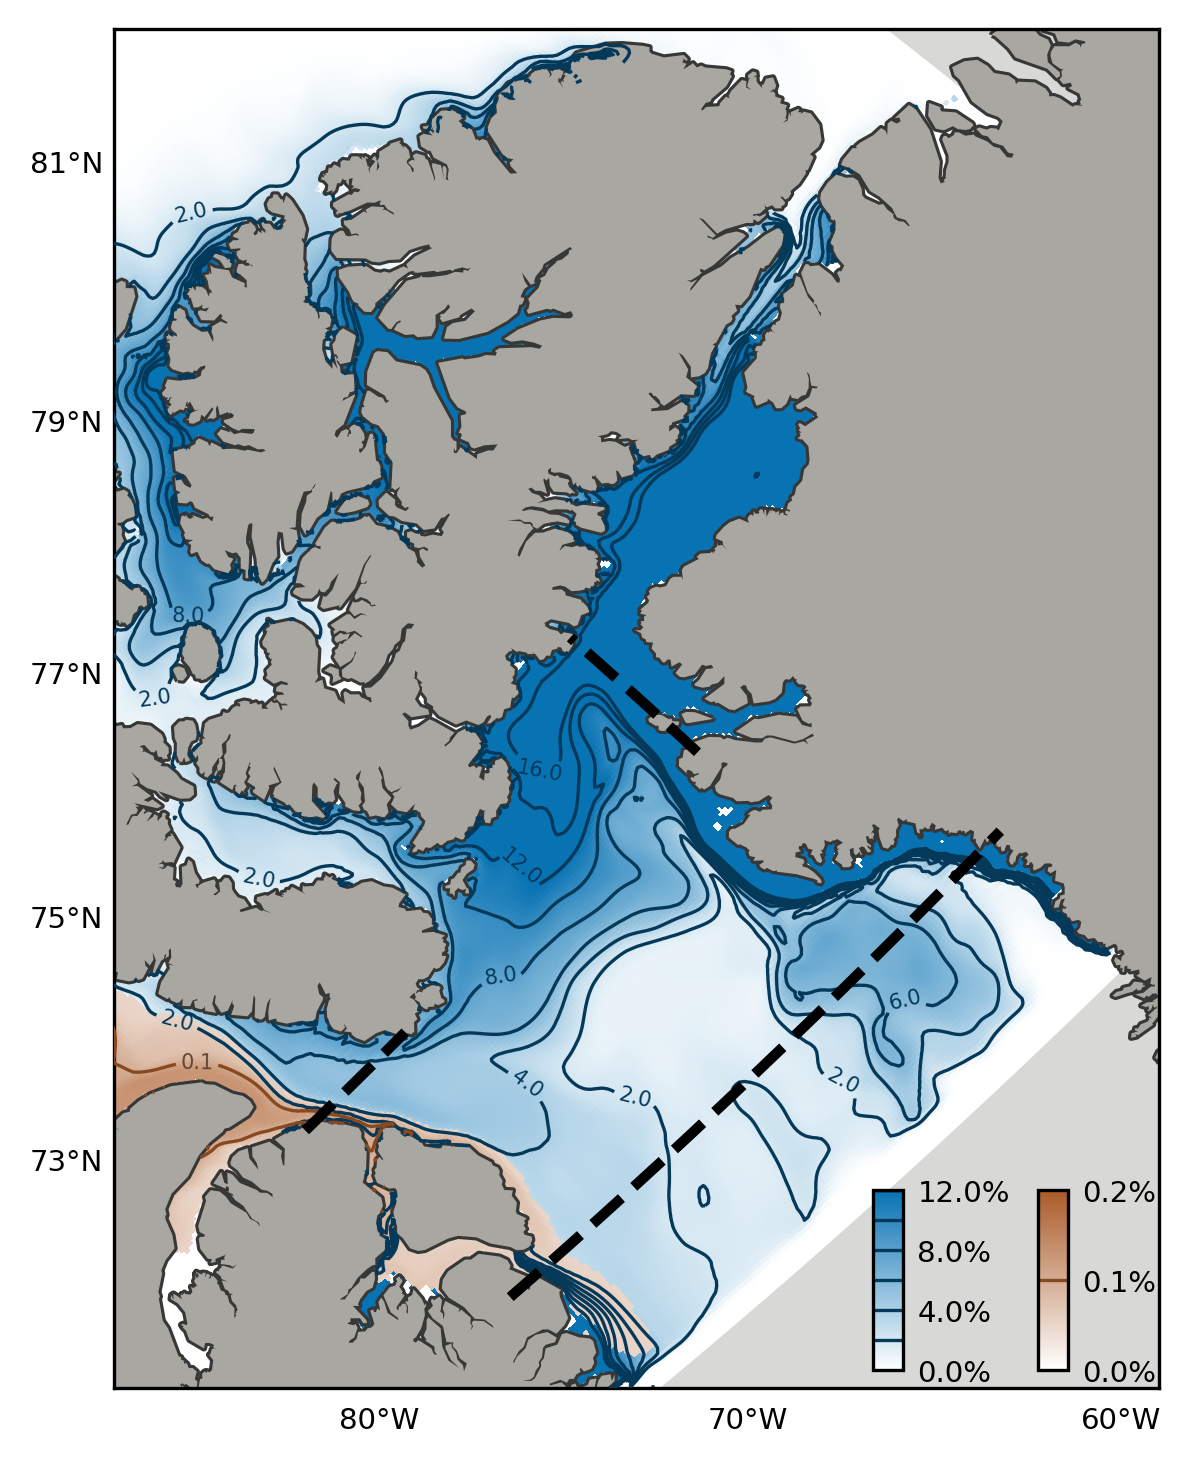

In [13]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/nares-strait.pickle','rb'))

#---------------------
x_model, y_model   = proj1(lon_sub, lat_sub)
x_ANHA12, y_ANHA12 = proj1(lon_ANHA12, lat_ANHA12)

# Coloured contours:
vmin_cont = 0; vmax_cont = 0.2; 
vmin_glac = 0; vmax_glac = 12;
CS1 = proj1.pcolormesh(x_model, y_model, ma_glac[month,:,:], vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)
CS2 = proj1.pcolormesh(x_model, y_model, ma_cont[month,:,:], vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap)

# Contour lines:
glac_levels = [2, 4, 6, 8, 10, 12, 14, 16]
cont_levels = [0.1]
glac = proj1.contour(x_model, y_model, ma_glac[month,:,:], levels=glac_levels, colors='#04395a', linewidths=0.8, zorder=4)
cont = proj1.contour(x_model, y_model, ma_cont[month,:,:], levels=cont_levels, colors='#894920', linewidths=0.8, zorder=4)

# Draw flux boundaries
proj1.plot(x_model[P1i, P1j], y_model[P1i, P1j], '--k', linewidth=2.5, zorder=4)
proj1.plot(x_model[r1i, r1j], y_model[r1i, r1j], '--k', linewidth=2.5, zorder=4)
proj1.plot(x_model[N1i, N1j], y_model[N1i, N1j], '--k', linewidth=2.5, zorder=4)

# Draw domain boundaries:
# consider adding plus rimwidth of boundary
ax1.fill_between(x_ANHA12[imin,:], y_ANHA12[imin,:], y_ANHA12[imin-200,:], color='#d8d8d6')
ax1.fill_between(x_ANHA12[:,jmax], y_ANHA12[:,jmax], y_ANHA12[:,jmax+100], color='#d8d8d6')

# Contour line labels:
manual_locations_cont = [(8e4, 3e5)]
manual_locations_glac = [(1.4e5, 5e5), (4.1e5, 6e5), (3.9e5, 5e5), (3.7e5, 4e5), (4e5, 3e5), (5e5, 3e5), (7e5, 3e5), \
                         (7.5e5, 4e5), (4e4, 6.5e5), (7e4, 7.5e5), (7e4, 1.2e6), (5e4, 3e5)]
ax1.clabel(glac, [2, 4, 6, 8, 10, 12, 14, 16], inline=1, fontsize=5, manual=manual_locations_glac, fmt='%.1f')
ax1.clabel(cont, [0.1]  , inline=1, fontsize=5, manual=manual_locations_cont, colors='#624532', fmt='%.1f')

# Colorbars:
cbaxes1 = fig.add_axes([0.67, 0.135, 0.02, 0.1])  
cbaxes2 = fig.add_axes([0.78, 0.135, 0.02, 0.1])
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=[0,4,8,12])
CBar2   = plt.colorbar(CS2, ax=ax1, cax=cbaxes2, ticks=[0,0.1,0.2])  
CBar1.add_lines(glac)
CBar2.add_lines(cont)

for CBar in [CBar1, CBar2]:
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    CBar.ax.zorder = 7
    CBar.ax.set_yticklabels([f'{i:.1f}%' for i in CBar.get_ticks()])

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/R2-Nares.jpg', bbox_inches='tight', dpi=300)